Following Pytorch Vision tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
from __future__ import print_function, division
from PIL import Image
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

import fastai.vision.learner

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
IN_PATH = '../input/'
N_FOLDS = 5
BS = 64
NUM_WORKERS = 4

DEBUG = True
valid_fold = [0] #[]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
train = pd.read_csv(IN_PATH + 'train.csv').sample(frac=1, random_state = 2021).reset_index(drop = True)
train['image'] = IN_PATH + 'train_images_512/' + train.chain.astype('str') + '/' + train.image


submission = pd.read_csv(IN_PATH + 'sample_submission.csv')
test = submission.copy()

In [4]:
train.head()

,image,chain,hotel_id,timestamp
0,../input/train_images_512/6/c6eff421216cc6e8.jpg,6,57161,2017-01-28 04:07:19
1,../input/train_images_512/3/92f8e8f497bd3500.jpg,3,28991,2016-06-28 01:41:56
2,../input/train_images_512/78/d22fcef5090ec3c8.jpg,78,22719,2016-07-23 19:40:15
3,../input/train_images_512/2/d8b078dea60e172b.jpg,2,42953,2019-03-02 17:27:27
4,../input/train_images_512/53/87def8a45811a68f.jpg,53,26682,2019-11-30 02:22:52


In [5]:

skf = StratifiedKFold(n_splits=N_FOLDS, random_state=None, shuffle=False)

train.kfold = -1

for f, (t,v) in enumerate(skf.split(X = train, y = train.hotel_id.values)):
    train.loc[v, 'kfold'] = f

train.groupby('kfold')['hotel_id'].count()

/opt/conda/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


kfold
0.0    19512
1.0    19511
2.0    19511
3.0    19511
4.0    19511
Name: hotel_id, dtype: int64

In [6]:
    
train_folds = sorted(list(set(range(N_FOLDS))-set(valid_fold)))

print(f'train folds: {train_folds}, valid fold = {valid_fold}')

train folds: [1, 2, 3, 4], valid fold = [0]


In [7]:
if DEBUG:

    train['chain_bucket']=train['chain'].map({0:1,
                                               6:2,
                                               5:3,
                                               90:4,
                                               3:4,
                                               89:4,
                                               87:5,
                                               4:5,
                                               2:5,
                                               88:5,
                                               9:6,
                                               82:6,
                                               78:6}).fillna(0)
    
    train = train[train.chain_bucket==6]


# Dataset

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.Pad(256, padding_mode='reflect'),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.Pad(256, padding_mode='reflect'),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [9]:
class ImgDFDataset(torch.utils.data.Dataset):

    
    def __init__(self, df, image_path_col = 'image', target_var = None, transform = None, folds = None):
        
        self.target_var = target_var
        
        if self.target_var is not None:
            self.is_train = True
        else:
            self.is_train = False
        
        self.targets = {}
        
        if self.is_train:
            self.data = df[df['kfold'].isin(folds)]
            self.classes, self.class_to_idx = self._find_classes(self.data, self.target_var)
            for t in self.target_var:
                self.targets[t] = torch.LongTensor(self.data[t].map(self.class_to_idx[t]).values)
        else:
            self.data = df
        
        self.image_paths = self.data[image_path_col].values
            
        self.transform = transform

    # https://pytorch.org/vision/stable/_modules/torchvision/datasets/folder.html#ImageFolder
    def _find_classes(self, data, target_var):
        classes = {}
        class_to_idx = {}
        for t in target_var:
            classes[t] = data[t].drop_duplicates().sort_values().values.tolist()
            class_to_idx[t] = {cls_name: i for i, cls_name in enumerate(classes[t])}
        return classes, class_to_idx
        
    def __len__(self):
        return self.data.shape[0]

    
    def __getitem__(self, item):
        
        img = Image.open(self.image_paths[item]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        target = {}
        if self.is_train:
            for t in self.target_var:
                target[t] = self.targets[t][item]

        return {'input': img, 'target': target}
        

In [10]:
train_dataset = ImgDFDataset(df = train, 
                            image_path_col = 'image',
                            target_var = ['hotel_id', 'chain'],
                            transform = data_transforms['train'],
                            folds = train_folds)

valid_dataset = ImgDFDataset(df = train, 
                            image_path_col = 'image',
                            target_var = ['hotel_id', 'chain'],
                            transform = data_transforms['valid'],
                            folds = valid_fold)

test_dataset = ImgDFDataset(df = test, 
                            image_path_col = 'image',
                            target_var = None,
                            transform = data_transforms['valid'],
                            folds = None
                           )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BS, shuffle = True, num_workers = NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BS, shuffle = False, num_workers = NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BS, shuffle = False, num_workers = NUM_WORKERS)

class_names = train_dataset.classes


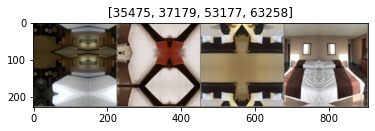

In [11]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


sample_size = 4
# Get a batch of training data
batch = next(iter(train_loader))
inputs, classes = batch['input'], batch['target']

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:sample_size])

imshow(out, title=[class_names['hotel_id'][x] for x in classes['hotel_id'][:sample_size]]) # [class_names[x] for x in classes])

In [12]:
def run_epoch(dataloader, model, criterion, optimizer, is_train = True, verbose = False, aux_w = 0.5):
    # https://pytorch.org/docs/stable/notes/amp_examples.html#working-with-scaled-gradients
    scaler = GradScaler()
    if is_train:
        model.train()
    else:
        model.eval()
    
    final_loss = {'outs': 0, 'outs_aux' : 0}
    running_corrects = {'outs': 0, 'outs_aux' : 0}
    running_k5 = {'outs': 0, 'outs_aux' : 0}
    targets = {}
    preds = {}
    loss_w = {'outs': 1-aux_w, 'outs_aux' : aux_w}

    num_batches = int(len(dataloader.dataset) / dataloader.batch_size)
    
    if verbose:
        tk = tqdm(dataloader, total = num_batches)
    else:
        tk = dataloader

    # for each batch
    for batch in tk:
        inputs = batch['input'].to(DEVICE, dtype = torch.float)
        targets['outs'] = batch['target']['hotel_id'].to(DEVICE, dtype = torch.long)
        targets['outs_aux'] = batch['target']['chain'].to(DEVICE, dtype = torch.long)
        
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_train):
            with autocast():
                loss_all = 0
                # forward step
                outputs = model(inputs)
                #_, preds = torch.max(outputs, 1)
                for out_type in ['outs', 'outs_aux']:
                    if not is_train:
                        k = min(5, outputs[out_type].shape[1])
                        preds[out_type] = outputs[out_type].topk(k = k, dim = -1)[1]

                        running_corrects[out_type] += (preds[out_type][:,0]==targets[out_type]).sum().double()
                        for rk in range(k):
                            running_k5[out_type] += ((preds[out_type][:,rk]==targets[out_type]).sum().double())#/(rk+1))

                    loss = criterion(outputs[out_type], targets[out_type])
                    final_loss[out_type] += loss
                    loss_all += (loss * loss_w[out_type])

            # backward + optimize only if in training phase
            if is_train:
                # get gradients
                scaler.scale(loss_all).backward()
                # apply gradient
                scaler.step(optimizer)
                
                scaler.update()
        
    if verbose:
        tk.close()
        
    return (final_loss['outs'] / num_batches, 
            running_corrects['outs'] / len(dataloader.dataset), 
            running_k5['outs'] / len(dataloader.dataset),
            final_loss['outs_aux'] / num_batches, 
            running_corrects['outs_aux'] / len(dataloader.dataset), 
           )
        
    

In [13]:
class HotelPool(nn.Module):
    def __init__(self, f_in, f_out):
        super(HotelPool, self).__init__()
    
    

class HotelHead(nn.Module):
    
    def __init__(self, f_in, f_out, f_out_aux):
        super(HotelHead, self).__init__()
        
        self.bn1 = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do1 = nn.Dropout(0.25)
        self.lin1 = nn.Linear(f_in, f_in, bias = False)
        self.rl = nn.ReLU(inplace=True)
        
        self.bn2 = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do2 = nn.Dropout(0.5)
        self.lin2 = nn.Linear(f_in, f_out, bias = False)
        
        self.bn2a = nn.BatchNorm1d(f_in, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.do2a = nn.Dropout(0.5)
        self.lin2a = nn.Linear(f_in, f_out_aux, bias = False)
        
        
    def forward(self, x):
        
        x = self.bn1(x)
        x = self.do1(x)
        x = self.lin1(x)
        x1 = self.rl(x)
        
        x = self.bn2(x1)
        x = self.do2(x)
        x = self.lin2(x)
        
        x_aux = self.bn2a(x1)
        x_aux = self.do2a(x_aux)
        x_aux = self.lin2a(x_aux)
        
        return {'outs': x, 'outs_aux': x_aux}
                
        

In [14]:
def freeze():
    for name, child in model.named_children():

        if name == 'fc':
            for param in child.parameters():
                param.requires_grad = True
        else:
            for param in child.parameters():
                param.requires_grad = False

def unfreeze():
    for param in model.parameters():
        param.requires_grad = True

In [15]:
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features

model.avgpool = fastai.layers.AdaptiveConcatPool2d()
model.fc = HotelHead(num_ftrs*2, len(class_names['hotel_id']), len(class_names['chain']))

model= model.to(DEVICE)

criterion = nn.CrossEntropyLoss() #BCEWithLogitsLoss() #

optimizer =  torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-3) #optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#one_cycle_sched =  torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 5e-2, steps_per_epoch=len(train_loader), epochs=EPOCHS)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler =lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#len(optimizer.param_groups[0])
optimizer =  torch.optim.Adam([{'params': o.parameters()} for p, o in model.named_children()], lr=5e-3, weight_decay=1e-3) #optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
one_cycle_sched =  torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = np.linspace(1e-6, 5e-3, 10).round(8).tolist(), steps_per_epoch=len(train_loader), epochs=EPOCHS-FREEZE_EPOCHS)

unfreeze()
for epoch in range(EPOCHS-FREEZE_EPOCHS):
    train_loss, _, _, train_aux_loss, _  = run_epoch(train_loader, model, criterion, optimizer, is_train=True, verbose = False, aux_w = 0.5-0.05*epoch)
    val_loss, acc, top5, val_aux_loss, acc_aux = run_epoch(valid_loader, model, criterion, optimizer, is_train=False, verbose = False)
    print(f'|     {epoch+FREEZE_EPOCHS} |     {train_loss:.4f} |   {val_loss:.4f} | {acc:.4f} | {top5:.4f} |         {train_aux_loss:.4f} |       {val_aux_loss:.4f} |   {acc_aux:.4f} |')
    one_cycle_sched.step()

In [16]:
train

,image,chain,hotel_id,timestamp,kfold,chain_bucket
0,../input/train_images_512/6/c6eff421216cc6e8.jpg,6,57161,2017-01-28 04:07:19,0.0,2.0
1,../input/train_images_512/3/92f8e8f497bd3500.jpg,3,28991,2016-06-28 01:41:56,0.0,4.0
2,../input/train_images_512/78/d22fcef5090ec3c8.jpg,78,22719,2016-07-23 19:40:15,0.0,6.0
3,../input/train_images_512/2/d8b078dea60e172b.jpg,2,42953,2019-03-02 17:27:27,0.0,5.0
4,../input/train_images_512/53/87def8a45811a68f.jpg,53,26682,2019-11-30 02:22:52,0.0,0.0
...,...,...,...,...,...,...
97551,../input/train_images_512/69/83939bb26cb464f4.jpg,69,16214,2017-04-13 20:03:39,4.0,0.0
97552,../input/train_images_512/82/ea115fcc35f68e80.jpg,82,11894,2017-07-19 11:56:57,4.0,6.0
97553,../input/train_images_512/5/87b77f3a10c0c26e.jpg,5,49314,2017-08-25 03:51:19,4.0,3.0
97554,../input/train_images_512/89/facf45321a49c4e3.jpg,89,3976,2017-04-25 01:51:08,4.0,4.0


In [17]:
%%time
print('| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |')
print('|-------|------------|----------|--------|--------|----------------|--------------|----------|')

FREEZE_EPOCHS = 10
EPOCHS=3

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-3) #
#optimizer =  optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
one_cycle_sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                       max_lr = 5e-3, #cycle_momentum=False,
                                                       pct_start=0.99, 
                                                       div_factor=5, 
                                                       final_div_factor=1e5,
                                                       cycle_momentum=False,
                                                       steps_per_epoch=len(train_loader), 
                                                       epochs=FREEZE_EPOCHS)

freeze()
for epoch in range(FREEZE_EPOCHS):
    train_loss, _, _, train_aux_loss, _ = run_epoch(train_loader, model, criterion, optimizer, is_train=True, verbose = False, aux_w = 0.5-0.05*epoch)
    val_loss, acc, top5, val_aux_loss, acc_aux = run_epoch(valid_loader, model, criterion, optimizer, is_train=False, verbose = False)
    print(f'|    {epoch}* |     {train_loss:.4f} |   {val_loss:.4f} | {acc:.4f} | {top5:.4f} |         {train_aux_loss:.4f} |       {val_aux_loss:.4f} |   {acc_aux:.4f} |')
    one_cycle_sched.step()

# discriminative learning rate
prm_grps = [{'params': c.parameters()} for c in model.children()]
optimizer =  torch.optim.Adam(prm_grps, lr=2.5e-3, weight_decay=1e-3) #optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
one_cycle_sched =  torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                       max_lr = np.linspace(2.5e-5, 2.5e-3, len(prm_grps)).round(8).tolist(), 
                                                       div_factor=5,
                                                       final_div_factor=1e5,
                                                       cycle_momentum=False,
                                                       steps_per_epoch=len(train_loader), 
                                                       epochs=EPOCHS-FREEZE_EPOCHS)

unfreeze()
for epoch in range(EPOCHS-FREEZE_EPOCHS):
    train_loss, _, _, train_aux_loss, _  = run_epoch(train_loader, model, criterion, optimizer, is_train=True, verbose = False, aux_w = 0) #0.5-0.05*epoch)
    val_loss, acc, top5, val_aux_loss, acc_aux = run_epoch(valid_loader, model, criterion, optimizer, is_train=False, verbose = False)
    print(f'|     {epoch+FREEZE_EPOCHS} |     {train_loss:.4f} |   {val_loss:.4f} | {acc:.4f} | {top5:.4f} |         {train_aux_loss:.4f} |       {val_aux_loss:.4f} |   {acc_aux:.4f} |')
    one_cycle_sched.step()

| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     8.5969 |   9.1929 | 0.0004 | 0.0011 |         3.3971 |       3.1759 |   0.2217 |
|    1* |     8.2167 |   9.1993 | 0.0005 | 0.0011 |         3.1368 |       3.1491 |   0.2257 |
|    2* |     8.1744 |   9.2058 | 0.0005 | 0.0013 |         3.1296 |       3.1575 |   0.2246 |
|    3* |     8.1444 |   9.2073 | 0.0005 | 0.0009 |         3.1395 |       3.1651 |   0.2282 |
|    4* |     8.1103 |   9.2117 | 0.0008 | 0.0015 |         3.1438 |       3.1659 |   0.2250 |
|    5* |     8.0696 |   9.2014 | 0.0007 | 0.0020 |         3.1550 |       3.1727 |   0.2242 |
|    6* |     8.0255 |   9.2430 | 0.0007 | 0.0017 |         3.1668 |       3.1947 |   0.2253 |
|    7* |     7.9777 |   9.2672 | 0.0003 | 0.0012 |         3.1881 |       3.2054 |   0.2230 |
|    8* |     7.9373 |   9.2558 | 0.0004 | 0.0015 

ValueError: Expected positive integer epochs, but got -7

In [18]:
| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     8.6476 |   9.1921 | 0.0007 | 0.0021 |         3.3684 |       2.9702 |   0.2606 |
|    1* |     8.3085 |   9.2356 | 0.0012 | 0.0021 |         3.1038 |       2.9636 |   0.2558 |

res18 adamW discLR div_F50(freeze)
| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     6.6850 |   6.1375 | 0.0558 | 0.0815 |         1.0106 |       0.7209 |   0.7027 |
|    1* |     5.8850 |   5.8797 | 0.0813 | 0.1131 |         0.8482 |       0.6794 |   0.7223 |
|    2* |     5.4662 |   5.7413 | 0.0987 | 0.1352 |         0.8337 |       0.6569 |   0.7393 |
|    3* |     5.1524 |   5.6904 | 0.1054 | 0.1463 |         0.8123 |       0.6492 |   0.7330 |
|    4* |     4.9552 |   5.7071 | 0.1214 | 0.1605 |         0.8146 |       0.6475 |   0.7433 |
|     5 |     4.5091 |   5.3199 | 0.1701 | 0.2167 |         0.6930 |       0.4742 |   0.8237 |
|     6 |     4.0589 |   5.1656 | 0.1884 | 0.2384 |         0.5695 |       0.4308 |   0.8460 |
|     7 |     3.8080 |   4.9743 | 0.2152 | 0.2702 |         0.5282 |       0.4239 |   0.8522 |
|     8 |     3.5510 |   4.9132 | 0.2353 | 0.2874 |         0.4946 |       0.4013 |   0.8625 |
|     9 |     3.3955 |   4.8815 | 0.2397 | 0.2993 |         0.4862 |       0.3992 |   0.8585 |
CPU times: user 1min 11s, sys: 14.1 s, total: 1min 25s
Wall time: 3min 9s

#18 all
| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     8.6810 |   9.1423 | 0.0008 | 0.0011 |         3.3424 |       3.0058 |   0.2474 |
|    1* |     8.5193 |   9.1623 | 0.0004 | 0.0006 |         3.1379 |       3.0259 |   0.2463 |
|    2* |     8.5229 |   9.1686 | 0.0005 | 0.0009 |         3.1546 |       3.0447 |   0.2510 |
#50 all


#18 chain4
| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     6.6090 |   6.1051 | 0.0518 | 0.0753 |         0.9831 |       0.7159 |   0.7018 |
|    1* |     5.8592 |   5.8839 | 0.0777 | 0.1124 |         0.8697 |       0.7081 |   0.6964 |
|    2* |     5.4631 |   5.7544 | 0.0893 | 0.1263 |         0.8294 |       0.6848 |   0.7232 |
|    3* |     5.2281 |   5.6328 | 0.1027 | 0.1396 |         0.7978 |       0.6606 |   0.7286 |
|    4* |     5.0829 |   5.6045 | 0.1045 | 0.1433 |         0.7921 |       0.6720 |   0.7228 |
|     5 |     4.7195 |   5.2270 | 0.1589 | 0.2010 |         0.6473 |       0.5061 |   0.8161 |
|     6 |     4.3125 |   5.0632 | 0.1826 | 0.2293 |         0.5465 |       0.4497 |   0.8469 |
|     7 |     4.0614 |   4.9359 | 0.1982 | 0.2503 |         0.5068 |       0.4188 |   0.8527 |
|     8 |     3.8824 |   4.8928 | 0.2045 | 0.2556 |         0.4867 |       0.4128 |   0.8576 |
|     9 |     3.6907 |   4.7549 | 0.2268 | 0.2818 |         0.4685 |       0.4292 |   0.8379 |
CPU times: user 1min 25s, sys: 13.1 s, total: 1min 38s
            Wall time: 3min 7s

#50mixed prec chain4
| EPOCH | train_loss | val_loss |   acc  |  top5  | train_aux_loss | val_aux_loss | acc_aux  |
|-------|------------|----------|--------|--------|----------------|--------------|----------|
|    0* |     7.7879 |   7.4365 | 0.0612 | 0.0805 |         1.2977 |       0.8124 |   0.6996 |
|    1* |     7.0658 |   6.8155 | 0.0786 | 0.1103 |         0.9818 |       0.6941 |   0.7223 |
|    2* |     6.1357 |   6.2820 | 0.0915 | 0.1262 |         0.8343 |       0.6267 |   0.7424 |
|     3 |     4.9084 |   5.2673 | 0.1696 | 0.2204 |         0.6639 |       0.4605 |   0.8335 |
|     4 |     3.9189 |   4.9834 | 0.2312 | 0.2828 |         0.5138 |       0.4363 |   0.8460 |
|     5 |     3.4248 |   4.8252 | 0.2491 | 0.3056 |         0.4747 |       0.4188 |   0.8567 |
|     6 |     2.9968 |   4.6200 | 0.2902 | 0.3462 |         0.4404 |       0.4118 |   0.8545 |
|     7 |     2.7185 |   4.5947 | 0.2835 | 0.3490 |         0.4139 |       0.4190 |   0.8442 |
|     8 |     2.5171 |   4.5429 | 0.3085 | 0.3697 |         0.4125 |       0.3808 |   0.8598 |
|     9 |     2.2810 |   4.4789 | 0.3281 | 0.3913 |         0.4098 |       0.3919 |   0.8701 |
CPU times: user 3min 59s, sys: 19.1 s, total: 4min 18s
Wall time: 5min 8s

SyntaxError: invalid syntax (<ipython-input-18-e0d2296cda4b>, line 1)

In [ ]:
#50e
| EPOCH | train_loss | val_loss |   acc  |  top5  |
|-------|------------|----------|--------|--------|
|     0 |     6.5428 |   6.4654 | 0.0112 | 0.0282 |
|     1 |     6.1507 |   6.2493 | 0.0259 | 0.0480 |
|     2 |     5.8046 |   5.9298 | 0.0576 | 0.0843 |
|     3 |     5.4242 |   5.7301 | 0.0790 | 0.1195 |
|     4 |     5.0118 |   5.4711 | 0.1089 | 0.1516 |
|     5 |     4.6499 |   5.4328 | 0.1321 | 0.1747 |
|     6 |     4.3744 |   5.3200 | 0.1504 | 0.2026 |
|     7 |     4.1214 |   5.2099 | 0.1540 | 0.2082 |
|     8 |     3.9063 |   5.1348 | 0.1768 | 0.2380 |
|     9 |     3.7199 |   5.0324 | 0.2076 | 0.2659 |
CPU times: user 5min 15s, sys: 3min 26s, total: 8min 41s
Wall time: 9min 3s

#model 18
| EPOCH | train_loss | val_loss |   acc  |  top5  |
|-------|------------|----------|--------|--------|
|    0 |     6.5223 |   6.2294 | 0.0415 | 0.0643 |
|    1 |     5.8311 |   5.8102 | 0.0987 | 0.1296 |
|    2 |     5.3717 |   5.5318 | 0.1295 | 0.1674 |
|    3 |     4.9438 |   5.2829 | 0.1621 | 0.1958 |
|    4 |     4.5953 |   5.1579 | 0.1804 | 0.2193 |
|    5 |     4.2920 |   5.0178 | 0.1924 | 0.2393 |
|    6 |     4.0415 |   4.8746 | 0.2076 | 0.2571 |
|    7 |     3.8112 |   4.8188 | 0.2344 | 0.2784 |
|    8 |     3.6103 |   4.7991 | 0.2246 | 0.2751 |
|    9 |     3.3989 |   4.6299 | 0.2625 | 0.3129 |
CPU times: user 2min 24s, sys: 13.2 s, total: 2min 37s
Wall time: 3min 28s
    

| EPOCH | train_loss | val_loss |   acc  |  top5  |
|-------|------------|----------|--------|--------|
|    0* |     6.8783 |   6.5295 | 0.0232 | 0.0370 |
|     1 |     6.4548 |   6.0950 | 0.0571 | 0.0828 |
|     2 |     5.9116 |   5.7865 | 0.0830 | 0.1199 |
|     3 |     5.4646 |   5.4988 | 0.1076 | 0.1465 |
|     4 |     5.1021 |   5.2896 | 0.1482 | 0.1847 |
|     5 |     4.7630 |   5.1072 | 0.1728 | 0.2091 |
|     6 |     4.4504 |   4.9560 | 0.1920 | 0.2352 |
|     7 |     4.2010 |   4.8943 | 0.2036 | 0.2496 |
|     8 |     3.9920 |   4.7872 | 0.2165 | 0.2644 |
|     9 |     3.8007 |   4.7630 | 0.2183 | 0.2713 |
CPU times: user 2min 10s, sys: 11.8 s, total: 2min 22s
Wall time: 3min 16s

In [ ]:
model